In [1]:
import pandas as pd

df = pd.DataFrame(columns=['Date', 'Ticker', 'Ticker Average Title Sentiment', 'Ticker Average Body Sentiment', 'Total Average Sentiment', "Next Day Ticker Price Change Direction", "5 Day Ticker Price Change Direction"])
df

,Date,Ticker,Ticker Average Title Sentiment,Ticker Average Body Sentiment,Total Average Sentiment,Next Day Ticker Price Change Direction,5 Day Ticker Price Change Direction


In [2]:
import numpy as np 
import pandas as pd 
import json
from matplotlib import pyplot as plt
with open('saps.json') as f:
  data = json.load(f)

# Displaying Subreddits 
subList = list(data.keys())
# print(subList)

In [3]:
for sub in subList:
    data[sub]['raw']['postData'] = pd.DataFrame(data = np.array(data[sub]['raw']['postData']), columns = ['Ticker','title','text','flair','unix'])
    data[sub]['raw']['postData']['rowInd'] = data[sub]['raw']['postData'].index
    # For each financial data type
    for finType in ['inter','intra']:
    
        # Get a list of post keys
        keyList = list(data[sub]['raw'][finType].keys())
    
        # For each keys, get the financial data for that post
        for key in keyList:
            data[sub]['raw'][finType][key] = np.array(data[sub]['raw'][finType][key])
            data[sub]['raw'][finType][key] = pd.Series(data[sub]['raw'][finType][key][:,1], index = data[sub]['raw'][finType][key][:,0])

In [4]:

# keys = data['Stocks']['md']['inter']['keys']
# sample = data['Stocks']['raw']['inter'][keys[1100]]
# sample_df = pd.DataFrame(data = sample).reset_index()
# sample_df.columns = ['unix','percentChange']
# sample_df['date'] = pd.to_datetime(sample_df['unix'],unit='s', utc=True)
# sample_df['date'] = sample_df['date'].dt.date
# # sample_df = sample_df.set_index('date')
# # sample_df['cumulativeChange'] = sample_df.groupby('date')['percentChange'].cumsum()
# display(sample_df.tail(20))
# # data['Stocks']['raw']['postData'].loc[0]
# display(data['Stocks']['raw']['postData'].loc[1100])
# sample_ticker = data['Stocks']['raw']['postData']['ticker'][1100]
# post_unix = data['Stocks']['raw']['postData']['unix'][1100]
# pd.to_datetime(post_unix,unit='s', utc=True).tz_convert('US/Eastern')

In [5]:
postData_df = pd.DataFrame()
for sub in subList:
    subData_df = data[sub]['raw']['postData']
    subData_df['subreddit'] = sub
    postData_df = pd.concat([postData_df, subData_df], axis = 0)

postData_df['Date'] = pd.to_datetime(postData_df['unix'], unit = 's', utc = True)
postData_df['Date'] = postData_df['Date'].dt.tz_convert('US/Eastern').dt.date
postData_df = postData_df.drop(columns = ['unix'])
postData_df.reset_index(drop = True, inplace = True)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_43744\4096438045.py:7: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  postData_df['Date'] = pd.to_datetime(postData_df['unix'], unit = 's', utc = True)


In [6]:
sentiment_df = pd.read_csv('Sentiment.csv', parse_dates=['Date'])
sentiment_df['Date'] = sentiment_df['Date'].apply(lambda x: x.date())
sentiment_df.columns = ['Ticker', 'Date', 'Title Sentiment', 'Body Sentiment']
postData_df = postData_df.merge(sentiment_df, on = ['Ticker', 'Date'], how = 'left')
postData_df['Market Average Sentiment'] = postData_df.groupby(['Date'])[['Title Sentiment', 'Body Sentiment']].transform('mean').mean(axis = 1)
# postData_df['Daily Ticker Title Average Sentiment'] = postData_df.groupby(['Date', 'Ticker'])['Title Sentiment'].transform('mean')
# postData_df['Daily Ticker Body Average Sentiment'] = postData_df.groupby(['Date', 'Ticker'])['Body Sentiment'].transform('mean')

In [7]:
# ! pip install yfinance
import yfinance as yf

model_input = postData_df[['Date', 'Ticker', 'Market Average Sentiment', 'Title Sentiment', 'Body Sentiment']].groupby(['Date', 'Ticker']).agg({'Title Sentiment': 'mean', 'Body Sentiment': 'mean', 'Market Average Sentiment': 'mean'}).reset_index()
model_input.dropna(subset=['Title Sentiment', 'Body Sentiment', 'Market Average Sentiment'], how='all', inplace=True)
start_date = model_input['Date'].min() - pd.Timedelta(days=5)
end_date = model_input['Date'].max() + pd.Timedelta(days=10)

# # Download all data at once
# tickers = model_input['ticker'].unique().tolist()
# ticker_string = " ".join(tickers)  # Convert list of tickers into a space-separated string
# data = yf.download(ticker_string, start=start_date, end=end_date)

In [8]:
# data.to_pickle("stock_data.pkl")

In [9]:
data = pd.read_pickle("stock_data.pkl")

In [10]:
all_dates = pd.DataFrame(index=pd.date_range(start=start_date, end=end_date, freq='D'))
all_dates.reset_index(inplace=True)
all_dates.columns = ['Date']
all_dates['Date'] = all_dates['Date'].dt.date

In [11]:
next_day_pct_change = data['Close'].pct_change().__deepcopy__()
next_day_pct_change.dropna(axis = 1, how='all', inplace = True)
next_day_pct_change = next_day_pct_change.shift(-1)
next_day_pct_change.dropna(axis = 0, how='all', inplace = True)
next_day_pct_change.reset_index(inplace = True)
next_day_pct_change['Date'] = pd.to_datetime(next_day_pct_change['Date']).dt.date
next_day_pct_change = next_day_pct_change.merge(all_dates, on = 'Date', how = 'right').fillna(method='bfill')
next_day_pct_change = next_day_pct_change.melt(id_vars = 'Date', var_name = 'Ticker', value_name = 'Next Day Price Change')
next_day_pct_change.dropna(subset=['Next Day Price Change'], inplace=True)
next_day_pct_change['Next Day Price Change Direction'] = (next_day_pct_change['Next Day Price Change'] > 0).astype(int)
# display(next_day_pct_change)

In [12]:
next_5d_pct_change = data['Close'].pct_change(5).__deepcopy__()
next_5d_pct_change.dropna(axis = 1, how='all', inplace = True)
next_5d_pct_change = next_5d_pct_change.shift(-5)
next_5d_pct_change.dropna(axis = 0, how='all', inplace = True)
next_5d_pct_change.reset_index(inplace = True)
next_5d_pct_change['Date'] = pd.to_datetime(next_5d_pct_change['Date']).dt.date
next_5d_pct_change = next_5d_pct_change.merge(all_dates, on = 'Date', how = 'right').fillna(method='bfill')
next_5d_pct_change = next_5d_pct_change.melt(id_vars = 'Date', var_name = 'Ticker', value_name = 'Next 5 Day Price Change')
next_5d_pct_change.dropna(subset=['Next 5 Day Price Change'], inplace=True)
next_5d_pct_change['Next 5 Day Price Change Direction'] = (next_5d_pct_change['Next 5 Day Price Change'] > 0).astype(int)
next_5d_pct_change['Date'] = pd.to_datetime(next_5d_pct_change['Date']).dt.date
# display(next_5d_pct_change)

In [13]:
model_input = model_input.merge(next_day_pct_change, how='left', on=['Date', 'Ticker'])
model_input = model_input.merge(next_5d_pct_change, how='left', on=['Date', 'Ticker'])
model_input.drop(columns=['Next 5 Day Price Change'], inplace=True)
model_input.dropna(subset=['Next Day Price Change Direction', 'Next 5 Day Price Change Direction'], inplace=True)

model_input[['Title Sentiment', 'Body Sentiment', 'Market Average Sentiment']] = model_input[['Title Sentiment', 'Body Sentiment', 'Market Average Sentiment']].replace(0, np.nan)
model_input.dropna(subset=['Title Sentiment', 'Body Sentiment', 'Market Average Sentiment'], how='all', inplace=True)
model_input[['Title Sentiment', 'Body Sentiment', 'Market Average Sentiment']] = model_input[['Title Sentiment', 'Body Sentiment', 'Market Average Sentiment']].fillna(0)

# model_input.dropna(subset=['Next Day Ticker Price Change Direction', '5 Day Ticker Price Change Direction'], inplace=True)
display(model_input)

,Date,Ticker,Title Sentiment,Body Sentiment,Market Average Sentiment,Next Day Price Change,Next Day Price Change Direction,Next 5 Day Price Change Direction
5,2017-03-30,GAIN,0.526700,0.00000,0.263350,0.002210,1.0,0.0
6,2017-03-30,IDXG,0.526700,0.00000,0.263350,-0.108475,0.0,0.0
8,2017-05-18,FOSL,-0.648600,0.38180,-0.133400,0.002435,1.0,0.0
9,2017-07-08,HERO,0.817600,0.00000,0.408800,0.023619,1.0,1.0
10,2017-07-10,CARA,0.296000,0.95580,0.625900,0.028665,1.0,1.0
...,...,...,...,...,...,...,...,...
29064,2020-09-23,NKLA,0.000000,0.59940,0.273513,-0.096927,0.0,0.0
29065,2020-09-23,QYLD,0.000000,0.67575,0.273513,0.001431,1.0,1.0
29066,2020-09-23,SPY,0.389150,0.18060,0.273513,0.002665,1.0,1.0
29067,2020-09-23,TSLA,0.000000,0.99770,0.273513,0.019534,1.0,1.0


In [14]:
spy_data = yf.download('SPY', start=start_date, end=end_date)
spy_data = spy_data['Close'].pct_change().reset_index()
full_date_range = pd.DataFrame({'Date': pd.date_range(start=start_date, end=end_date)})
full_date_range["Date"] = full_date_range["Date"].dt.date
spy_data['Date'] = pd.to_datetime(spy_data['Date']).dt.date
spy_data = full_date_range.merge(spy_data, on='Date', how='left')
spy_data.fillna(method='ffill', inplace=True)
spy_data = spy_data.rename(columns={'Close': 'SPY'})
model_input = model_input.merge(spy_data, on='Date', how='left')
model_input.dropna(subset=['SPY'], inplace=True)
display(model_input)
model_input.to_csv('model_input.csv', index=False)

[*********************100%%**********************]  1 of 1 completed


,Date,Ticker,Title Sentiment,Body Sentiment,Market Average Sentiment,Next Day Price Change,Next Day Price Change Direction,Next 5 Day Price Change Direction,SPY
0,2017-03-30,GAIN,0.526700,0.00000,0.263350,0.002210,1.0,0.0,0.003184
1,2017-03-30,IDXG,0.526700,0.00000,0.263350,-0.108475,0.0,0.0,0.003184
2,2017-05-18,FOSL,-0.648600,0.38180,-0.133400,0.002435,1.0,0.0,0.004028
3,2017-07-08,HERO,0.817600,0.00000,0.408800,0.023619,1.0,1.0,0.006485
4,2017-07-10,CARA,0.296000,0.95580,0.625900,0.028665,1.0,1.0,0.001074
...,...,...,...,...,...,...,...,...,...
24031,2020-09-23,NKLA,0.000000,0.59940,0.273513,-0.096927,0.0,0.0,-0.023191
24032,2020-09-23,QYLD,0.000000,0.67575,0.273513,0.001431,1.0,1.0,-0.023191
24033,2020-09-23,SPY,0.389150,0.18060,0.273513,0.002665,1.0,1.0,-0.023191
24034,2020-09-23,TSLA,0.000000,0.99770,0.273513,0.019534,1.0,1.0,-0.023191


In [15]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

# Load the dataset
model_input = pd.read_csv('model_input.csv')

# Convert 'Date' to datetime and extract the date part
model_input['Date'] = pd.to_datetime(model_input['Date']).dt.date

# Drop rows with missing target values
model_input.dropna(subset=['Next Day Price Change Direction',
                   'Next 5 Day Price Change Direction'], inplace=True)

# Select first 80% of the data for training
train_size = int(0.8 * model_input.shape[0])
train_data = model_input.iloc[:train_size].copy()
test_data = model_input.iloc[train_size:].copy()

# Drop unnecessary columns and prepare features and targets
X_train = train_data.drop(columns=['Date', 'Ticker', 'Next Day Price Change Direction', 'Next 5 Day Price Change Direction', 'Next Day Price Change'])
y_next_day_train = train_data['Next Day Price Change Direction']
y_5_day_train = train_data['Next 5 Day Price Change Direction']

X_test = test_data.drop(columns=['Date', 'Ticker', 'Next Day Price Change Direction', 'Next 5 Day Price Change Direction', 'Next Day Price Change'])
y_next_day_test = test_data['Next Day Price Change Direction']
y_5_day_test = test_data['Next 5 Day Price Change Direction']

# Scaling features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define parameters for GridSearchCV
param_grid = {
    'n_estimators': [20, 50, 100, 200, 300],  # Number of trees in the forest
    'max_depth': [5, 10, 20, None],  # Maximum depth of the tree
    'min_samples_split': [2, 5,7],
    'min_samples_leaf': [1, 2,3,5]
}

# Initialize RandomForestClassifier
rf = RandomForestClassifier(random_state=42)

# Grid search for the next day prediction
grid_search_next_day = GridSearchCV(
    estimator=rf, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_next_day.fit(X_train, y_next_day_train)

# Retrieve and print the best parameters and the best score for the next day prediction
best_params_next_day = grid_search_next_day.best_params_
best_score_next_day = grid_search_next_day.best_score_
print("Best parameters for next day prediction:", best_params_next_day)
print("Best accuracy for next day prediction:", best_score_next_day)

# Retrain the best model on the entire dataset for next day prediction
best_clf_next_day = grid_search_next_day.best_estimator_
best_clf_next_day.fit(X_train, y_next_day_train)
y_pred_next_day = best_clf_next_day.predict(X_test)
print(classification_report(y_next_day_test, y_pred_next_day))

test_data['Predicted Next Day Price Change Direction'] = y_pred_next_day

# Grid search for the 5-day prediction
grid_search_5_day = GridSearchCV(
    estimator=rf, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_5_day.fit(X_train, y_5_day_train)

# Retrieve and print the best parameters and the best score for the 5-day prediction
best_params_5_day = grid_search_5_day.best_params_
best_score_5_day = grid_search_5_day.best_score_
print("Best parameters for 5-day prediction:", best_params_5_day)
print("Best accuracy for 5-day prediction:", best_score_5_day)

# Retrain the best model on the entire dataset for 5-day prediction
best_clf_5_day = grid_search_5_day.best_estimator_
best_clf_5_day.fit(X_train, y_5_day_train)
y_pred_5_day = best_clf_5_day.predict(X_test)
test_data['Predicted 5 Day Price Change Direction'] = y_pred_5_day

# Save the DataFrame with predictions
test_data.to_csv('model_output_with_predictions.csv', index=False)

# Print out some of the DataFrame to check
test_data

Best parameters for next day prediction: {'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}
Best accuracy for next day prediction: 0.5160176550104917
              precision    recall  f1-score   support

         0.0       0.56      0.82      0.66      2687
         1.0       0.44      0.18      0.26      2121

    accuracy                           0.54      4808
   macro avg       0.50      0.50      0.46      4808
weighted avg       0.51      0.54      0.48      4808

Best parameters for 5-day prediction: {'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
Best accuracy for 5-day prediction: 0.510454108671499


,Date,Ticker,Title Sentiment,Body Sentiment,Market Average Sentiment,Next Day Price Change,Next Day Price Change Direction,Next 5 Day Price Change Direction,SPY,Predicted Next Day Price Change Direction,Predicted 5 Day Price Change Direction
19228,2020-07-16,EOD,0.000000,-0.46780,0.095803,0.004566,1.0,1.0,-0.003293,0.0,0.0
19229,2020-07-16,EPAZ,0.000000,0.00000,0.095803,0.212121,1.0,1.0,-0.003293,0.0,0.0
19230,2020-07-16,EPS,-0.226300,-0.15310,0.095803,0.000291,1.0,1.0,-0.003293,0.0,0.0
19231,2020-07-16,ERBB,0.000000,0.00000,0.095803,0.000000,0.0,0.0,-0.003293,0.0,0.0
19232,2020-07-16,EXPE,0.000000,0.00000,0.095803,-0.003441,0.0,0.0,-0.003293,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
24031,2020-09-23,NKLA,0.000000,0.59940,0.273513,-0.096927,0.0,0.0,-0.023191,1.0,1.0
24032,2020-09-23,QYLD,0.000000,0.67575,0.273513,0.001431,1.0,1.0,-0.023191,1.0,1.0
24033,2020-09-23,SPY,0.389150,0.18060,0.273513,0.002665,1.0,1.0,-0.023191,1.0,1.0
24034,2020-09-23,TSLA,0.000000,0.99770,0.273513,0.019534,1.0,1.0,-0.023191,1.0,1.0


In [16]:
test_data = test_data[test_data['Ticker'] != 'ROTH']
test_data.to_csv('model_output_with_predictions.csv', index=False)

Backtesting Progress: 100%|██████████| 70/70 [00:00<00:00, 916.65it/s]


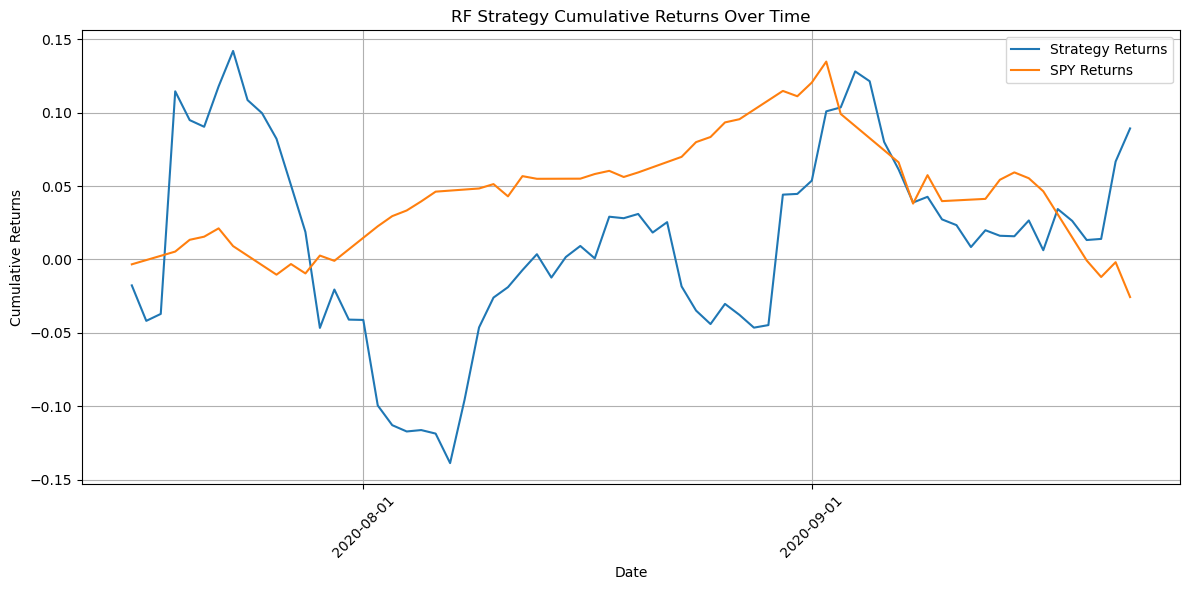

-----------------------------------------------------
Strategy Metrics:
Stock Strategy Cumulative Return: 8.92%
SPY Strategy Cumulative Return: -2.56%


In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates 
from tqdm import tqdm


class DirectStockTradeBacktester:
    def __init__(self, data, initial_capital=1000000):
        self.data = data
        self.initial_capital = initial_capital
        self.cash = initial_capital
        self.spy_cash = initial_capital
        self.stock_returns = [0]  # Start with 0 return on the first day
        self.spy_returns = [0]  # Start with 0 return on the first day
        self.log = []


    def run_backtest(self, direction = 1):
        grouped_data = self.data.groupby('Date')

        # Initialize the cumulative returns lists with zeros for each day available
        num_days = len(self.data['Date'].unique())
        self.stock_returns = [0] * num_days
        self.spy_returns = [0] * num_days

        day_counter = 0
        for date, group in tqdm(grouped_data, desc="Backtesting Progress"):
            daily_return = 0
            spy_return = 0

            buy_stocks = group[group['Predicted Next Day Price Change Direction'] == direction]
            if not buy_stocks.empty:
                investment_per_stock = (self.cash ) / len(buy_stocks)
                for _, row in buy_stocks.iterrows():
                    stock_return = investment_per_stock * row['Next Day Price Change']
                    daily_return += stock_return if direction == 1 else -stock_return

            # Update daily returns for stock strategy
            if day_counter == 0:
                self.stock_returns[day_counter] = daily_return / self.initial_capital
            else:
                self.stock_returns[day_counter] = self.stock_returns[day_counter -
                                                                    1] + daily_return / self.initial_capital

            # SPY strategy
            spy_return = self.spy_cash * group.iloc[0]['SPY']
            self.spy_cash += spy_return
            if day_counter == 0:
                self.spy_returns[day_counter] = spy_return / self.spy_cash
            else:
                self.spy_returns[day_counter] = self.spy_returns[day_counter -
                                                                1] + spy_return / self.spy_cash

            day_counter += 1  # Increment day counter after processing each group


    def plot_cumulative_returns(self, title = 'Strategy Cumulative Returns Over Time'):
        plt.figure(figsize=(12, 6))
        dates = self.data['Date'].unique()
        plt.plot(dates, self.stock_returns, label='Strategy Returns')
        plt.plot(dates, self.spy_returns, label='SPY Returns')
        plt.xlabel('Date')
        plt.ylabel('Cumulative Returns')
        plt.title(title)
        plt.legend()
        # Set the locator
        locator = mdates.MonthLocator()  # Shows the first day of each month
        plt.gca().xaxis.set_major_locator(locator)

        # Set the formatter
        formatter = mdates.DateFormatter('%Y-%m-%d')
        plt.gca().xaxis.set_major_formatter(formatter)

        plt.grid(True)
        plt.xticks(rotation=45)  # Rotate date labels for better visibility
        plt.tight_layout()  # Adjust layout to make room for label rotation
        plt.show()

    def display_log(self):
        # Display the stored log
        for entry in self.log:
            print(
                f"Date: {entry[0]}, Stock PnL: {entry[1]:.2f}, SPY PnL: {entry[2]:.2f}")



    def calculate_metrics(self):
        stock_cumulative_return = self.stock_returns[-1]
        spy_cumulative_return = self.spy_returns[-1]
        print("-----------------------------------------------------")
        print("Strategy Metrics:")
        print(
            f"Stock Strategy Cumulative Return: {stock_cumulative_return:.2%}")
        print(f"SPY Strategy Cumulative Return: {spy_cumulative_return:.2%}")


# Load your data
data = pd.read_csv('model_output_with_predictions.csv')
data['Date'] = pd.to_datetime(data['Date']).dt.date

# Initialize the backtester
backtester = DirectStockTradeBacktester(data)

# Run the backtest
backtester.run_backtest(0)

# Plot cumulative returns
backtester.plot_cumulative_returns('RF Strategy Cumulative Returns Over Time')

# Calculate and print metrics
backtester.calculate_metrics()

# Display transaction log
backtester.display_log()

In [18]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

# Function to get the default device

def get_device():
    return 'cuda' if torch.cuda.is_available() else 'cpu'


device = get_device()
print("Using device:", device)

# Load your data
model_input = pd.read_csv('model_input.csv')
model_input['Date'] = pd.to_datetime(model_input['Date'])
model_input['Date'] = model_input['Date'].dt.date
model_input.dropna(subset=['Next Day Price Change Direction',
                   'Next 5 Day Price Change Direction'], inplace=True)

# Maintain original indices for later merging
original_indices = model_input.index

# Select first 80% of the data for training
train_size = int(0.8 * model_input.shape[0])
train_data = model_input.iloc[:train_size].copy()
test_data = model_input.iloc[train_size:].copy()

# Drop unnecessary columns and prepare features and targets
X_train = train_data.drop(columns=['Date', 'Ticker', 'Next Day Price Change Direction', 'Next 5 Day Price Change Direction', 'Next Day Price Change'])
y_next_day_train = train_data['Next Day Price Change Direction']
y_5_day_train = train_data['Next 5 Day Price Change Direction']

X_test = test_data.drop(columns=['Date', 'Ticker', 'Next Day Price Change Direction', 'Next 5 Day Price Change Direction', 'Next Day Price Change'])
indices_test_next_day = test_data.index
indices_test_5_day = test_data.index
y_next_day_test = test_data['Next Day Price Change Direction']
y_5_day_test = test_data['Next 5 Day Price Change Direction']

# Convert to PyTorch tensors
X_train = torch.tensor(X_train.values, dtype=torch.float32)
y_next_day_train = torch.tensor(y_next_day_train.values, dtype=torch.long)
y_5_day_train = torch.tensor(y_5_day_train.values, dtype=torch.long)

X_test = torch.tensor(X_test.values, dtype=torch.float32)
y_next_day_test = torch.tensor(y_next_day_test.values, dtype=torch.long)
y_5_day_test = torch.tensor(y_5_day_test.values, dtype=torch.long)

# Define the neural network

class Net(nn.Module):
    def __init__(self, X):
        super(Net, self).__init__()
        # Assuming input features size is the number of columns in X
        self.fc1 = nn.Linear(X.shape[1], 50)
        # Output size is 2 for binary classification
        self.fc2 = nn.Linear(50, 2)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Function to train and evaluate the model, returning predictions


def train_and_evaluate(X_train, X_test, y_train, y_test, epochs=50):
    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

    model = Net(X_train).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    model.train()
    for epoch in range(epochs):
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    # Testing the model and getting predictions
    model.eval()
    predictions = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            predictions.extend(predicted.cpu().numpy())

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()


    accuracy = 100 * correct / total
    print(f'Accuracy: {accuracy}%')
    return predictions


# Train for next day price change direction and append predictions
print("Training for Next Day Price Change Direction:")
predictions_next_day = train_and_evaluate(X_train, X_test, y_next_day_train, y_next_day_test)
test_data.loc[indices_test_next_day,
              'Predicted Next Day Price Change Direction'] = predictions_next_day

# Train for 5 day price change direction and append predictions
print("Training for 5 Day Price Change Direction:")
predictions_5_day = train_and_evaluate(X_train, X_test, y_5_day_train, y_5_day_test)
test_data.loc[indices_test_5_day,
              'Predicted 5 Day Price Change Direction'] = predictions_5_day

# Optionally, save or display the modified DataFrame
test_data.to_csv('nn.csv', index=False)
test_data.head(20)

Using device: cpu
Training for Next Day Price Change Direction:
Accuracy: 54.991680532445926%
Training for 5 Day Price Change Direction:
Accuracy: 49.7712146422629%


,Date,Ticker,Title Sentiment,Body Sentiment,Market Average Sentiment,Next Day Price Change,Next Day Price Change Direction,Next 5 Day Price Change Direction,SPY,Predicted Next Day Price Change Direction,Predicted 5 Day Price Change Direction
19228,2020-07-16,EOD,0.00000,-0.467800,0.095803,0.004566,1.0,1.0,-0.003293,0.0,0.0
19229,2020-07-16,EPAZ,0.00000,0.000000,0.095803,0.212121,1.0,1.0,-0.003293,0.0,0.0
19230,2020-07-16,EPS,-0.22630,-0.153100,0.095803,0.000291,1.0,1.0,-0.003293,0.0,0.0
19231,2020-07-16,ERBB,0.00000,0.000000,0.095803,0.000000,0.0,0.0,-0.003293,0.0,0.0
19232,2020-07-16,EXPE,0.00000,0.000000,0.095803,-0.003441,0.0,0.0,-0.003293,0.0,0.0
19233,2020-07-16,FAMI,0.00000,0.000000,0.095803,-0.027027,0.0,0.0,-0.003293,0.0,0.0
19234,2020-07-16,FOR,0.37895,0.437500,0.095803,0.078792,1.0,1.0,-0.003293,1.0,1.0
19235,2020-07-16,FUV,0.00000,0.098667,0.095803,-0.065041,0.0,0.0,-0.003293,0.0,1.0
19236,2020-07-16,GAN,0.00000,0.440400,0.095803,0.027250,1.0,0.0,-0.003293,0.0,1.0
19237,2020-07-16,GENE,0.00000,0.000000,0.095803,0.000000,0.0,0.0,-0.003293,0.0,0.0


              precision    recall  f1-score   support

           0       0.56      0.85      0.68      2687
           1       0.47      0.17      0.25      2121

    accuracy                           0.55      4808
   macro avg       0.52      0.51      0.46      4808
weighted avg       0.52      0.55      0.49      4808



Backtesting Progress:   0%|          | 0/70 [00:00<?, ?it/s]

Backtesting Progress: 100%|██████████| 70/70 [00:00<00:00, 2333.04it/s]


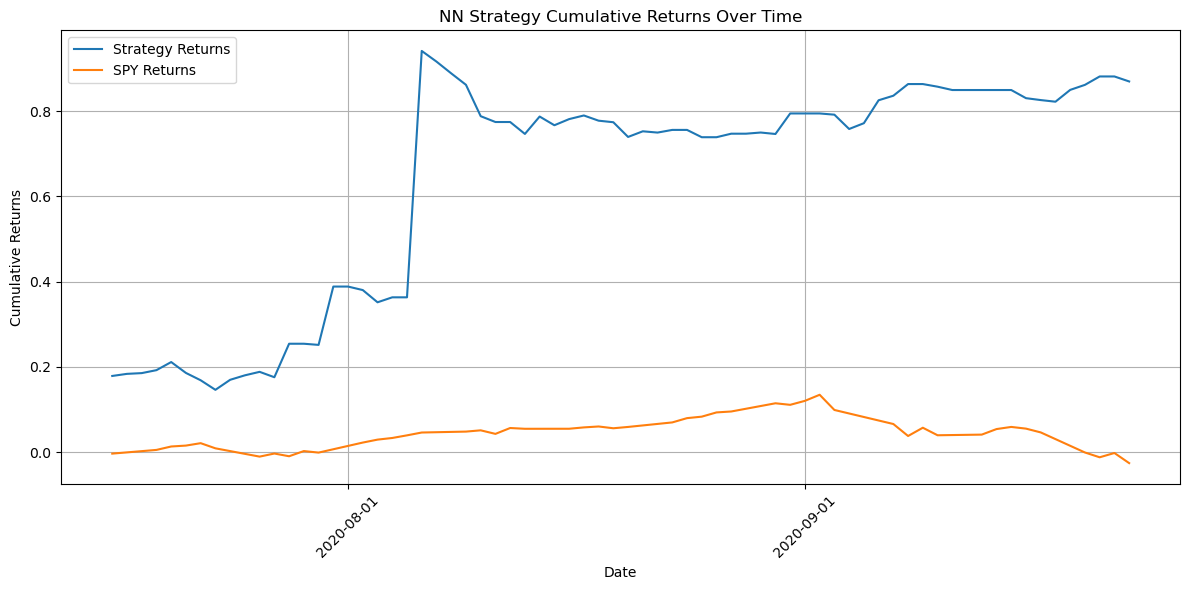

-----------------------------------------------------
Strategy Metrics:
Stock Strategy Cumulative Return: 86.94%
SPY Strategy Cumulative Return: -2.56%


In [19]:
print(classification_report(y_next_day_test, predictions_next_day))

test_data = pd.read_csv('nn.csv')
test_data['Date'] = pd.to_datetime(test_data['Date']).dt.date
nn_backtester = DirectStockTradeBacktester(test_data)
nn_backtester.run_backtest()
nn_backtester.plot_cumulative_returns('NN Strategy Cumulative Returns Over Time')
nn_backtester.calculate_metrics()
nn_backtester.display_log()

In [20]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

# Function to get the default device


def get_device():
    return 'cuda' if torch.cuda.is_available() else 'cpu'


device = get_device()
print("Using device:", device)

# Load your data
model_input = pd.read_csv('model_input.csv')
model_input['Date'] = pd.to_datetime(model_input['Date'])
model_input['Date'] = model_input['Date'].dt.date
model_input.dropna(subset=['Next Day Price Change Direction',
                   'Next 5 Day Price Change Direction'], inplace=True)

# Select first 80% of the data for training
train_size = int(0.8 * model_input.shape[0])
train_data = model_input.iloc[:train_size].copy()
test_data = model_input.iloc[train_size:].copy()

# Drop unnecessary columns and prepare features and targets
X_train = train_data.drop(columns=['Date', 'Ticker', 'Next Day Price Change Direction', 'Next 5 Day Price Change Direction', 'Next Day Price Change'])
y_next_day_train = train_data['Next Day Price Change Direction']
y_5_day_train = train_data['Next 5 Day Price Change Direction']

X_test = test_data.drop(columns=['Date', 'Ticker', 'Next Day Price Change Direction', 'Next 5 Day Price Change Direction', 'Next Day Price Change'])
indices_test_next_day = test_data.index
indices_test_5_day = test_data.index
y_next_day_test = test_data['Next Day Price Change Direction']
y_5_day_test = test_data['Next 5 Day Price Change Direction']

# Convert to PyTorch tensors
X_train = torch.tensor(X_train.values, dtype=torch.float32)
y_next_day_train = torch.tensor(y_next_day_train.values, dtype=torch.long)
y_5_day_train = torch.tensor(y_5_day_train.values, dtype=torch.long)

X_test = torch.tensor(X_test.values, dtype=torch.float32)
y_next_day_test = torch.tensor(y_next_day_test.values, dtype=torch.long)
y_5_day_test = torch.tensor(y_5_day_test.values, dtype=torch.long)

# Define the neural network


class Net(nn.Module):
    def __init__(self, X_train):
        super(Net, self).__init__()
        # Assuming input features size is the number of columns in X
        self.fc1 = nn.Linear(X_train.shape[1], 50)
        # Output size is 2 for binary classification
        self.fc2 = nn.Linear(50, 2)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Function to train and evaluate the model


def train_and_evaluate(X_train, y_train, X_test, y_test, epochs=50):
    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

    model = Net(X_train).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(epochs):
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    # Testing the model
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Accuracy: {accuracy}%')
    return accuracy


# Train for next day price change direction
print("Training for Next Day Price Change Direction:")
train_and_evaluate(X_train, y_next_day_train, X_test, y_next_day_test)

# Train for 5 day price change direction
print("Training for 5 Day Price Change Direction:")
train_and_evaluate(X_train, y_5_day_train, X_test, y_5_day_test)

Using device: cpu
Training for Next Day Price Change Direction:
Accuracy: 55.55324459234609%
Training for 5 Day Price Change Direction:
Accuracy: 45.257903494176375%


45.257903494176375

In [22]:
import pandas as pd
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, classification_report
# Load the dataset
model_input = pd.read_csv('model_input.csv')
model_input['Date'] = pd.to_datetime(model_input['Date']).dt.date

# Drop rows with missing target values
model_input.dropna(subset=['Next Day Price Change Direction',
                   'Next 5 Day Price Change Direction'], inplace=True)

# Select first 80% of the data for training
train_size = int(0.8 * model_input.shape[0])
train_data = model_input.iloc[:train_size].copy()
test_data = model_input.iloc[train_size:].copy()

# Drop unnecessary columns and prepare features and targets
X_train = train_data.drop(columns=['Date', 'Ticker', 'Next Day Price Change Direction', 'Next 5 Day Price Change Direction', 'Next Day Price Change'])
y_next_day_train = train_data['Next Day Price Change Direction']
y_5_day_train = train_data['Next 5 Day Price Change Direction']

X_test = test_data.drop(columns=['Date', 'Ticker', 'Next Day Price Change Direction', 'Next 5 Day Price Change Direction', 'Next Day Price Change'])
y_next_day_test = test_data['Next Day Price Change Direction']
y_5_day_test = test_data['Next 5 Day Price Change Direction']

# Scaling features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

param_grid = {
    'C': [0.1, 1, 10],  # Regularization parameter
    'kernel': ['linear', 'rbf', 'poly'],  # Type of SVM kernel
    'gamma': ['scale', 'auto'],  # Kernel coefficient
    'degree': [3, 4],  # Degree for the polynomial kernel, if used
}

# Initialize SVC
svm = SVC(random_state=42)

grid_search_next_day = GridSearchCV(
    estimator=svm, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_next_day.fit(X_train, y_next_day_train)
best_params_next_day = grid_search_next_day.best_params_
best_score_next_day = grid_search_next_day.best_score_
print("Best parameters for next day prediction:", best_params_next_day)
print("Best accuracy for next day prediction:", best_score_next_day)

# Retrain with the best parameters
best_svm_next_day = grid_search_next_day.best_estimator_
best_svm_next_day.fit(X_train, y_next_day_train)
y_pred_next_day = best_svm_next_day.predict(X_test)
test_data['Predicted Next Day Price Change Direction'] = y_pred_next_day

test_data.to_csv('model_output_with_svm_predictions.csv', index=False)
display(test_data)

KeyboardInterrupt: 

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         0.0       0.56      1.00      0.72      2687
         1.0       0.00      0.00      0.00      2121

    accuracy                           0.56      4808
   macro avg       0.28      0.50      0.36      4808
weighted avg       0.31      0.56      0.40      4808



Backtesting Progress: 100%|██████████| 70/70 [00:00<00:00, 714.88it/s]


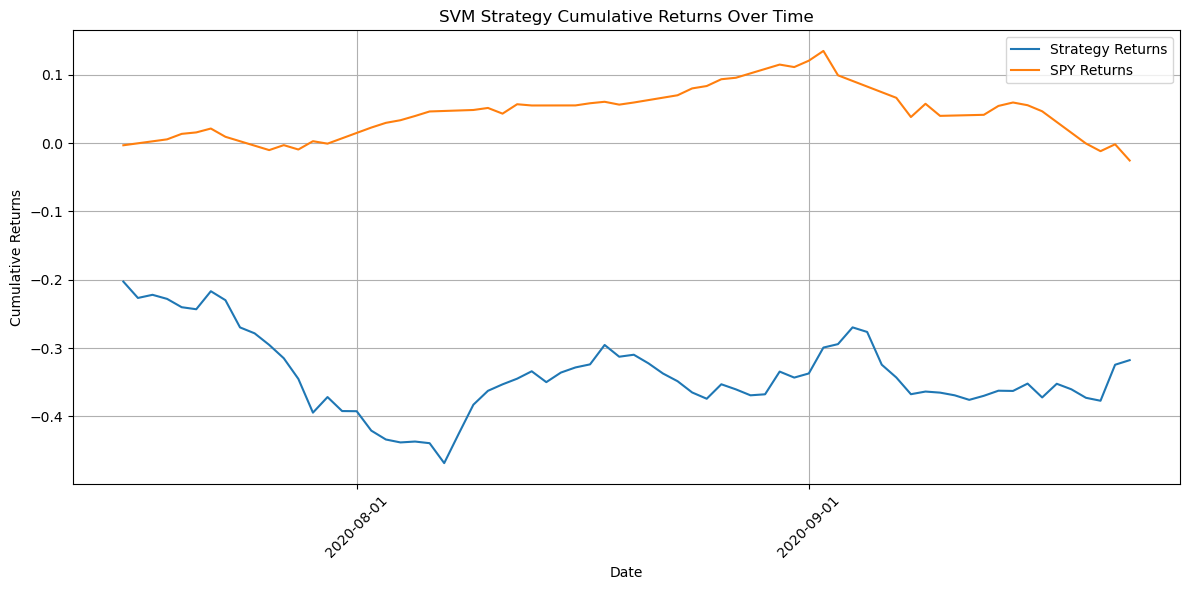

-----------------------------------------------------
Strategy Metrics:
Stock Strategy Cumulative Return: -31.76%
SPY Strategy Cumulative Return: -2.56%


In [ ]:
print(classification_report(y_next_day_test, y_pred_next_day))

svm_backtester = DirectStockTradeBacktester(test_data)
svm_backtester.run_backtest(direction=0)
svm_backtester.plot_cumulative_returns('SVM Strategy Cumulative Returns Over Time')
svm_backtester.calculate_metrics()
svm_backtester.display_log()